# LETID - Accelerated Tests


Several standardized accelerated tests have been developed for LETID. These include [IEC TS 63342](https://webstore.iec.ch/publication/67332) for c-Si photovoltaic modules, and [IEC TS 63202-4](https://webstore.iec.ch/publication/67612) for c-Si photovoltaic cells.
Both procedures essentially prescribe exposure to constant light or current injection at constant elevated temperature for a prescribed duration of time. This notebook demonstrates how to use this library to model device behavior in such a procedure.

**Requirements:**
- `pandas`, `numpy`, `matplotlib`

**Objectives:**
1. Define necessary solar cell device parameters
2. Define necessary degradation parameters: degraded lifetime and defect states
3. Create timeseries of temperature and current injection
4. Run through timeseries, calculating defect states
5. Calculate device degradation and plot



In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.3.3

In [2]:
from pvdeg import letid, collection, utilities, DATA_DIR

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvdeg
import datetime as dt

In [3]:
# This information helps with debugging and getting support :)
import sys
import platform

print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("pvdeg version ", pvdeg.__version__)

Working on a  Windows 11
Python version  3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]
Pandas version  2.2.3
pvdeg version  0.5.1.dev623+g51cc68b8e.d20250905


## Device parameters
To define a device, we need to define several important quantities about the device: wafer thickness (in $\mu m$), rear surface recombination velocity (in cm/s), and cell area (in cm<sup>2</sup>). The values defined below are representative of a typical PERC solar cell.

In [4]:
wafer_thickness = 180  # um
s_rear = 46  # cm/s
cell_area = 243  # cm^2

##### Other device parameters
Other required device parameters: base diffusivity (in $cm^2/s$), and optical generation profile, which allow us to estimate current collection in the device.

In [5]:
generation_df = pd.read_excel(
    os.path.join(DATA_DIR, "PVL_GenProfile.xlsx"), header=0
)  # this is an optical generation profile generated by PVLighthouse's OPAL2 default model for 1-sun, normal incident AM1.5 sunlight on a 180-um thick SiNx-coated, pyramid-textured wafer.
generation = generation_df["Generation (cm-3s-1)"]
depth = generation_df["Depth (um)"]

d_base = 27  # cm^2/s electron diffusivity. See https://www2.pvlighthouse.com.au/calculators/mobility%20calculator/mobility%20calculator.aspx for details

## Degradation parameters
To model the device's degradation, we need to define several more important quantities about the degradation the device will experience. These include undegraded and degraded lifetime (in $\mu s$).

In [6]:
tau_0 = 115  # us, carrier lifetime in non-degraded states, e.g. LETID/LID states A or C
tau_deg = 55  # us, carrier lifetime in fully-degraded state, e.g. LETID/LID state B

Let's see how much maximum power degradation these parameters will result in: 

In [7]:
loss, pmp_0, pmp_deg = letid.calc_pmp_loss_from_tau_loss(
    tau_0, tau_deg, cell_area, wafer_thickness, s_rear
)  # returns % power loss, pmp_0, pmp_deg
print(loss)

0.03495240755084558


<b> Check to see the device's current collection </b>

In [8]:
jsc_0 = collection.calculate_jsc_from_tau_cp(
    tau_0, wafer_thickness, d_base, s_rear, generation, depth
)  # returns short-circuit current (Jsc) in mA/cm^2 given required cell parameters
print(jsc_0)

41.59099692285122


<b> Remaining degradation parameters:</b>

The rest of the quantities to define are: the initial percentage of defects in each state (A, B, and C), and the dictionary of mechanism parameters.

In this example, we'll assume the device starts in the fully-undegraded state (100% state A), and we'll use the parameters for LETID degradation from Repins.

In [9]:
# starting defect state percentages
nA_0 = 100
nB_0 = 0
nC_0 = 0

In [10]:
# Here's a list of the possible sets of kinetic parameters from kinetic_parameters.json:
utilities.get_kinetics()

('Choose a set of kinetic parameters:',
 ['repins',
  'repins_best_case',
  'kwapil',
  'bredemeier',
  'wyller_wafer',
  'wyller_cell',
  'graf',
  'dark letid',
  'bo-lid',
  'Lit BO-LID + fit to Qcells destab'])

In [11]:
mechanism_params = utilities.get_kinetics("repins")
print(mechanism_params)

{'mechanism': 'LETID', 'v_ab': 46700000.0, 'v_ba': 4.7e-25, 'v_bc': 19900000.0, 'v_cb': 0.0, 'ea_ab': 0.827, 'ea_ba': -1.15, 'ea_bc': 0.871, 'ea_cb': 0.0, 'suns_ab': 1.0, 'suns_bc': 1.0, 'temperature_ab': 410, 'temperature_bc': 410, 'tau_ab': 75, 'tau_bc': 75, 'x_ab': 1, 'x_ba': 1.7, 'x_bc': 1.2, 'structure_ab': 'cell', 'structure_bc': 'cell', 'thickness_ab': 200, 'thickness_bc': 200, 'srv_ab': 90, 'srv_bc': 90, 'doi': 'doi:10.1557/s43577-022-00438-8', 'comments': ''}


## Set up timeseries
In this example, we are going to model test with constant temperature and current injection. IEC TS 63342 prescribes two to three weeks of injection equivalent to $2\times(I_{sc}-I_{mp})$, at $75\degree C$. For most typical c-Si modules, $2\times(I_{sc}-I_{mp})$ is roughly equal to $0.1\times I_{sc}$. So we will set injection equal to 0.1 "suns" of injection. 

We will create a pandas datetime series and calculate the changes in defect states for each timestep.

In [12]:
temperature = 75  # degrees celsius
suns = 0.1  # "suns" of injection, e.g 1-sun illumination at open circuit would be 1; dark current injection is given as a fraction of Isc, e.g., injecting Isc would be 1. For this example we assume injection is 0.1*Isc.

duration = "3W"
freq = "min"
start = "2022-01-01"

# default is 3 weeks of 1-minute interval timesteps. In general, we should select small timesteps unless we are sure defect reactions are proceeding very slowly
timesteps = pd.date_range(
    start, end=pd.to_datetime(start) + pd.to_timedelta(duration), freq=freq
)
timesteps = pd.DataFrame(timesteps, columns=["Datetime"])


temps = np.full(len(timesteps), temperature)
injection = np.full(len(timesteps), suns)

timesteps["Temperature"] = temps
timesteps["Injection"] = injection

timesteps[["NA", "NB", "NC", "tau"]] = (
    np.nan
)  # create columns for defect state percentages and lifetime, fill with NaNs for now, to fill iteratively below

timesteps.loc[0, ["NA", "NB", "NC"]] = (
    nA_0,
    nB_0,
    nC_0,
)  # assign first timestep defect state percentages
timesteps.loc[0, "tau"] = letid.tau_now(
    tau_0, tau_deg, nB_0
)  # calculate tau for the first timestep

In [13]:
timesteps

,Datetime,Temperature,Injection,NA,NB,NC,tau
0,2022-01-01 00:00:00,75,0.1,100.0,0.0,0.0,115.0
1,2022-01-01 00:01:00,75,0.1,NaN,NaN,NaN,NaN
2,2022-01-01 00:02:00,75,0.1,NaN,NaN,NaN,NaN
3,2022-01-01 00:03:00,75,0.1,NaN,NaN,NaN,NaN
4,2022-01-01 00:04:00,75,0.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
30236,2022-01-21 23:56:00,75,0.1,NaN,NaN,NaN,NaN
30237,2022-01-21 23:57:00,75,0.1,NaN,NaN,NaN,NaN
30238,2022-01-21 23:58:00,75,0.1,NaN,NaN,NaN,NaN
30239,2022-01-21 23:59:00,75,0.1,NaN,NaN,NaN,NaN


## Run through timesteps
Since each timestep depends on the preceding timestep, we need to calculate in a loop. This will take a few minutes depending on the length of the timeseries.

In [14]:
for index, timestep in timesteps.iterrows():
    # first row tau has already been assigned
    if index == 0:
        pass

    # loop through rows, new tau calculated based on previous NB. Reaction proceeds based on new tau.
    else:
        n_A = timesteps.at[index - 1, "NA"]
        n_B = timesteps.at[index - 1, "NB"]
        n_C = timesteps.at[index - 1, "NC"]

        tau = letid.tau_now(tau_0, tau_deg, n_B)
        jsc = collection.calculate_jsc_from_tau_cp(
            tau, wafer_thickness, d_base, s_rear, generation, depth
        )

        temperature = timesteps.at[index, "Temperature"]
        injection = timesteps.at[index, "Injection"]

        # calculate defect reaction kinetics: reaction constant and carrier concentration factor.
        k_AB = letid.k_ij(
            mechanism_params["v_ab"], mechanism_params["ea_ab"], temperature
        )
        k_BA = letid.k_ij(
            mechanism_params["v_ba"], mechanism_params["ea_ba"], temperature
        )
        k_BC = letid.k_ij(
            mechanism_params["v_bc"], mechanism_params["ea_bc"], temperature
        )
        k_CB = letid.k_ij(
            mechanism_params["v_cb"], mechanism_params["ea_cb"], temperature
        )

        x_ab = letid.carrier_factor(
            tau,
            "ab",
            temperature,
            injection,
            jsc,
            wafer_thickness,
            s_rear,
            mechanism_params,
        )
        x_ba = letid.carrier_factor(
            tau,
            "ba",
            temperature,
            injection,
            jsc,
            wafer_thickness,
            s_rear,
            mechanism_params,
        )
        x_bc = letid.carrier_factor(
            tau,
            "bc",
            temperature,
            injection,
            jsc,
            wafer_thickness,
            s_rear,
            mechanism_params,
        )

        # calculate the instantaneous change in NA, NB, and NC
        dN_Adt = (k_BA * n_B * x_ba) - (k_AB * n_A * x_ab)
        dN_Bdt = (
            (k_AB * n_A * x_ab) + (k_CB * n_C) - ((k_BA * x_ba + k_BC * x_bc) * n_B)
        )
        dN_Cdt = (k_BC * n_B * x_bc) - (k_CB * n_C)

        t_step = (
            timesteps.at[index, "Datetime"] - timesteps.at[index - 1, "Datetime"]
        ).total_seconds()

        # assign new defect state percentages
        timesteps.at[index, "NA"] = n_A + dN_Adt * t_step
        timesteps.at[index, "NB"] = n_B + dN_Bdt * t_step
        timesteps.at[index, "NC"] = n_C + dN_Cdt * t_step

## Finish calculating degraded device parameters.
Now that we have calculated defect states, we can calculate all the quantities that depend on defect states.

In [15]:
timesteps["tau"] = letid.tau_now(tau_0, tau_deg, timesteps["NB"])

# calculate device Jsc for every timestep. Unfortunately this requires an integration so I think we have to run through a loop. Device Jsc allows calculation of device Voc.
for index, timestep in timesteps.iterrows():
    jsc_now = collection.calculate_jsc_from_tau_cp(
        timesteps.at[index, "tau"], wafer_thickness, d_base, s_rear, generation, depth
    )
    timesteps.at[index, "Jsc"] = jsc_now
    timesteps.at[index, "Voc"] = letid.calc_voc_from_tau(
        timesteps.at[index, "tau"], wafer_thickness, s_rear, jsc_now, temperature=25
    )

In [16]:
# this function quickly calculates the rest of the device parameters: Isc, FF, max power, and normalized max power
timesteps = letid.calc_device_params(timesteps, cell_area=243)
timesteps["time (days)"] = (
    timesteps["Datetime"] - timesteps.iloc[0]["Datetime"]
).dt.total_seconds() / 86400  # create a column for days elapsed

timesteps

,Datetime,Temperature,Injection,NA,NB,NC,tau,Jsc,Voc,Isc,FF,Pmp,Pmp_norm,time (days)
0,2022-01-01 00:00:00,75,0.1,100.000000,0.000000,0.000000,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000,0.000000
1,2022-01-01 00:01:00,75,0.1,99.945424,0.054576,0.000000,114.931573,41.590784,0.666316,10.106561,0.840985,5.663325,0.999975,0.000694
2,2022-01-01 00:02:00,75,0.1,99.890904,0.109094,0.000002,114.863300,41.590572,0.666304,10.106509,0.840983,5.663184,0.999950,0.001389
3,2022-01-01 00:03:00,75,0.1,99.836439,0.163555,0.000006,114.795178,41.590359,0.666292,10.106457,0.840981,5.663043,0.999925,0.002083
4,2022-01-01 00:04:00,75,0.1,99.782028,0.217959,0.000012,114.727209,41.590147,0.666281,10.106406,0.840979,5.662902,0.999900,0.002778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30236,2022-01-21 23:56:00,75,0.1,0.006066,54.974093,45.019841,71.887698,41.381392,0.656754,10.055678,0.839286,5.542735,0.978682,20.997222
30237,2022-01-21 23:57:00,75,0.1,0.006065,54.972773,45.021162,71.888345,41.381397,0.656754,10.055679,0.839286,5.542738,0.978683,20.997917
30238,2022-01-21 23:58:00,75,0.1,0.006064,54.971454,45.022482,71.888992,41.381402,0.656754,10.055681,0.839286,5.542740,0.978683,20.998611
30239,2022-01-21 23:59:00,75,0.1,0.006063,54.970135,45.023802,71.889638,41.381407,0.656755,10.055682,0.839286,5.542743,0.978684,20.999306


## Plot the results



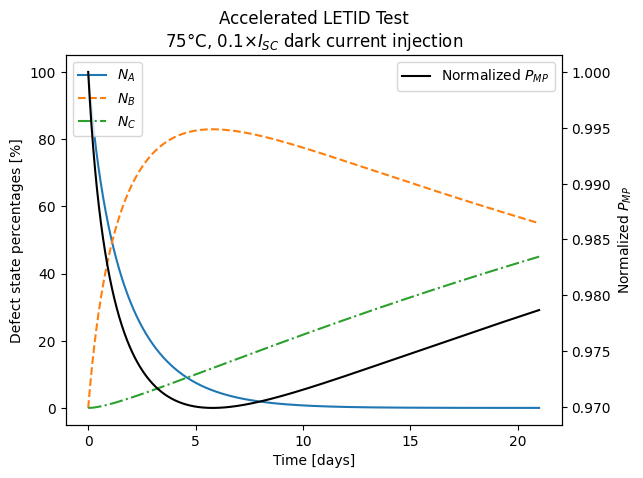

In [17]:
from cycler import cycler

plt.style.use("default")

fig, ax = plt.subplots()

ax.set_prop_cycle(
    cycler("color", ["tab:blue", "tab:orange", "tab:green"])
    + cycler("linestyle", ["-", "--", "-."])
)

ax.plot(timesteps["time (days)"], timesteps[["NA", "NB", "NC"]].values)

ax.legend(labels=["$N_A$", "$N_B$", "$N_C$", "80 % regeneration"], loc="upper left")
ax.set_ylabel("Defect state percentages [%]")
ax.set_xlabel("Time [days]")

ax2 = ax.twinx()
ax2.plot(
    timesteps["time (days)"],
    timesteps["Pmp_norm"],
    c="black",
    label="Normalized $P_{MP}$",
)
ax2.legend(loc="upper right")
ax2.set_ylabel("Normalized $P_{MP}$")

# ax.axvline(pvdeg.Degradation.calc_regeneration_time(timesteps).total_seconds()/(60*60*24), linestyle = ':' , c = 'grey')
# ax.annotate('80% regeneration', (pvdeg.Degradation.calc_regeneration_time(timesteps).total_seconds()/(60*60*24), 80),
#            xytext=(0.5, 0.8), textcoords='axes fraction',
#            arrowprops=dict(facecolor='black', shrink=0.1),
#            horizontalalignment='right', verticalalignment='top')

ax.set_title(
    "Accelerated LETID Test\n"
    rf"{temperature}$\degree$C, {suns}$\times I_{{SC}}$ dark current injection"
)

plt.show()

The function `calc_letid_lab` wraps all of the steps above into a single function:

In [18]:
FIXED_START_DATE = dt.datetime(2025, 9, 9, 0, 0)
result = letid.calc_letid_lab(
    tau_0, tau_deg, wafer_thickness, s_rear, nA_0, nB_0, nC_0, 0.1, 75, "repins",
    start=FIXED_START_DATE
)
result["Datetime"] = result["Datetime"].dt.round("s")
print(result)

                 Datetime  Temperature  Injection          NA         NB  \
0     2025-09-09 00:00:00           75        0.1  100.000000   0.000000   
1     2025-09-09 00:01:00           75        0.1   99.945424   0.054576   
2     2025-09-09 00:02:00           75        0.1   99.890904   0.109094   
3     2025-09-09 00:03:00           75        0.1   99.836439   0.163555   
4     2025-09-09 00:04:00           75        0.1   99.782028   0.217959   
...                   ...          ...        ...         ...        ...   
30236 2025-09-29 23:56:00           75        0.1    0.006066  54.974093   
30237 2025-09-29 23:57:00           75        0.1    0.006065  54.972773   
30238 2025-09-29 23:58:00           75        0.1    0.006064  54.971454   
30239 2025-09-29 23:59:00           75        0.1    0.006063  54.970135   
30240 2025-09-30 00:00:00           75        0.1    0.006061  54.968816   

              NC         tau        Jsc       Voc       Isc        FF  \
0       0.0000